In [2]:
import pandas as pd
import numpy as np

from collections import defaultdict
import sklearn.preprocessing
import scipy.sparse
import sklearn
import sklearn.linear_model
import sklearn.model_selection

import matplotlib.pyplot as plt
import seaborn as sns

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0


In [5]:
#Dummy data for regression

tmp_df = pd.DataFrame([['a',1,2],['b',3,4],['a',5,6],['b',7,8],['a',9,10],['b',11,12]])
tmp_df.columns = ['c1','c2','c3']
categorical_features = ['c1','c2']
X_train = X_test = pd.get_dummies(tmp_df[categorical_features])
Y_train = Y_test = tmp_df['c3']

enc_dict = defaultdict(sklearn.preprocessing.LabelEncoder)
ohe = sklearn.preprocessing.OneHotEncoder()
tmp_le_df = tmp_df[categorical_features].apply(lambda x : enc_dict[x.name].fit_transform(x))
ohe.fit(tmp_le_df)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [6]:
# Sample specific uncertainty intervals for regression models

# clf = sklearn.linear_model.LinearRegression()
# clf.fit(X_train, Y_train)
# Y_predictions = clf.predict(X_test)
# print(clf.coef_, clf.intercept_)

#--------------------------------------------------------------------------------

# ##Train/Test prediction intervals using statsmodel. Use bootstrap or below approaches
# #Theory: https://onlinecourses.science.psu.edu/stat414/node/298/
# #http://nbviewer.jupyter.org/gist/thatneat/10286720
# #https://www.learndatasci.com/tutorials/predicting-housing-prices-linear-regression-using-python-pandas-statsmodels/
# #https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html
# #https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

# Using stats model

# import statsmodels.api as sm
# from statsmodels.sandbox.regression.predstd import wls_prediction_std
# re = sm.OLS(Y_train, X_train).fit()
# print(re.summary())
# print('-'*80)
# prstd, iv_l, iv_u = wls_prediction_std(re)
# print(prstd, iv_l, iv_u)
# print('-'*80)
# prstd, iv_l, iv_u = wls_prediction_std(re, X_train.iloc[0:2]) #Test set can be invoked through this approach
# print(prstd, iv_l, iv_u)

# Using bootstrap 

from sklearn.ensemble import BaggingRegressor
n_estimators = 50
model = BaggingRegressor(sklearn.linear_model.LinearRegression(), n_estimators=n_estimators, bootstrap=True)
model.fit(X_train, Y_train)

#Inspecting uncertainty interval for a prediction at sample test point
test_sample = np.array([[1,2,3]])
res = []
for m in model.estimators_:
    res.append(m.predict(test_sample))
pd.DataFrame(res).describe()

/Users/maheshgoud/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/maheshgoud/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


,0
count,50.000000
mean,2.027579
std,0.126649
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,2.666667


In [7]:
# Embedding based Neural Network Regressor. Check out https://www.kaggle.com/aquatic/entity-embedding-neural-net

from keras import layers
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Input, Embedding, merge, Reshape, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

categorical_features = ['c1','c2']
numeric_features = []
predict_col_name = 'c3'
all_cols = categorical_features

## Reformatting train/test data for keras model

tmp_X_train, tmp_X_test = tmp_df, tmp_df
tmp_le_train_df = tmp_X_train[categorical_features].apply(lambda x: enc_dict[x.name].transform(x))
tmp_le_test_df = tmp_X_test[categorical_features].apply(lambda x: enc_dict[x.name].transform(x))

tmp_X_train_inp = []
tmp_X_test_inp = []
for c in all_cols:
    tmp_X_train_inp.append(np.array(tmp_le_train_df[c]))
    tmp_X_test_inp.append(np.array(tmp_le_test_df[c]))

print('Train test shape:', tmp_le_train_df.shape, tmp_le_test_df.shape)
tmp_num_feat = {}
for col in categorical_features:
    num_uniq_features = len(enc_dict[col].classes_)
    print (col, num_uniq_features)
    tmp_num_feat.update({col:num_uniq_features})  # Feature embedding based regression model using keras

embedding_size = 5
batch_size = 16

# # early_stopping = EarlyStopping(monitor='val_loss', patience=0)
# tmp_model_save_dir = '/Users/maheshgoud/Desktop/'
# tmp_model_save_filename = tmp_model_save_dir + 'model_tmp.h5'

## Keras model implementation

tmp_input_list = []
tmp_embedding_list = []
for idx, e_col in enumerate(all_cols):
    tmp_input = Input(shape=(1,), dtype='int32', name=e_col)
    tmp_embedding = Embedding(input_dim=tmp_num_feat[e_col], output_dim=embedding_size, input_length=1)(tmp_input)
    tmp_input_list.append(tmp_input)
    tmp_embedding_list.append(tmp_embedding)

x = layers.concatenate(tmp_embedding_list)
x = Reshape((len(tmp_embedding_list)*embedding_size,), name="reshape_one")(x)
x = Dense(64, activation='relu', name="dense_1")(x)
x = Dropout(.1)(x)
x = Dense(32, activation='relu', name="dense_2")(x)
tmp_model_output = Dense(1, activation='relu', name="dense_3")(x)

tmp_final_model = Model(input=tmp_input_list, output=tmp_model_output)
print(tmp_final_model.summary())

# mean_squared_error, mean_absolute_percentage_error, mean_squared_logarithmic_error
tmp_final_model.compile(loss='mean_absolute_percentage_error', optimizer='adadelta') #metrics=['accuracy']
tmp_final_model.fit(tmp_X_train_inp, Y_train.values, epochs=5, batch_size=batch_size, validation_split=0.1) #, callbacks=[early_stopping])

# tmp_final_model.save(tmp_model_save_filename)

Y_predictions = tmp_final_model.predict(tmp_X_test_inp, batch_size=batch_size)
mean_absolute_percentage_error(Y_test.values, Y_predictions) #TODO: Double check

# from ann_visualizer.visualize import ann_viz
# ann_viz(tmp_final_model)

/Users/maheshgoud/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train test shape: (6, 2) (6, 2)
c1 2
c2 6
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
c1 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
c2 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 5)         10          c1[0][0]                         
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 5)         30          c2[0][0]                         
___________________________________________________________________

/Users/maheshgoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Train on 5 samples, validate on 1 samples
Epoch 1/5
5/5 [==============================] - 1s 113ms/step - loss: 99.7596 - val_loss: 99.9103
Epoch 2/5
5/5 [==============================] - 0s 602us/step - loss: 99.4161 - val_loss: 99.7965
Epoch 3/5
5/5 [==============================] - 0s 605us/step - loss: 99.1371 - val_loss: 99.6767
Epoch 4/5
5/5 [==============================] - 0s 596us/step - loss: 98.6875 - val_loss: 99.5423
Epoch 5/5
5/5 [==============================] - 0s 749us/step - loss: 98.3369 - val_loss: 99.3850


98.10295776153605

In [8]:
#Dummy data for classification

tmp_df = pd.DataFrame([['a',1,0],['b',3,1],['a',5,0],['b',7,1],['a',9,0],['b',11,1]])
tmp_df.columns = ['c1','c2','c3']
categorical_features = ['c1','c2']

X_train = X_test = pd.get_dummies(tmp_df[categorical_features])
Y_train = Y_test = tmp_df['c3']


Accuracy: 100.0
             precision    recall  f1-score   support

        (0)       1.00      1.00      1.00         3
        (1)       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         6

ConfusionMatrix
 [[3 0]
 [0 3]]


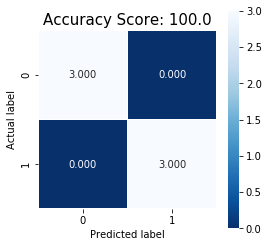

Model coefficients:


,feat,coef
2,c1_b,7.991014
0,c2,0.085760
1,c1_a,-8.325591


In [9]:
#Model evaluation on single train/test split for inspecting confusion matrix

clf = sklearn.linear_model.LogisticRegression(C=1e4)
clf.fit(X_train, Y_train)
Y_predictions = clf.predict(X_test)

#Evaluate predictions
score = 100.0*round(clf.score(X_test, Y_test),4)
print('Accuracy:',score)
print(sklearn.metrics.classification_report(Y_test, Y_predictions, target_names=['(0)','(1)']))
cm = sklearn.metrics.confusion_matrix(Y_test, Y_predictions)
print('ConfusionMatrix\n',cm)

#Color coded confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score: {0}'.format(score)
plt.title(title, size = 15)
plt.show()

#scikitplot can be used for roc curves. skipping for now

# #Precision/Recall curve
# y_scores = sklearn.model_selection.cross_val_predict(clf, X_train, Y_train, cv=3, method="decision_function")
# precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(Y_train, y_scores)

#Inspect model coefficients
print('Model coefficients:')
pd.DataFrame({'feat':X_train.columns,'coef':clf.coef_[0]}).sort_values(by=['coef'], ascending=[False])

In [10]:
#Categorical embedding + numerical data neural network classifier

#Embedding based neural network

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, merge, Reshape, Dropout, Input, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

def build_embeddingnetwork(df, categorical_cols, numeric_cols, timestamp_cols=None): 
    inputs, embeddings = [], []
    for c in categorical_cols:
        #Determined embedding dimension
        no_of_unique_cat  = df[c].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        #Create embedding
        cur_input = Input(shape=(1,), name=c)
        cur_embedding = Embedding(no_of_unique_cat+1, embedding_size, input_length=1)(cur_input)
        cur_embedding = Reshape(target_shape=(embedding_size,))(cur_embedding)
        inputs.append(cur_input)
        embeddings.append(cur_embedding)
    input_numeric = Input(shape=(len(numeric_cols),))
    embedding_numeric = Dense(16)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)

    x = Concatenate()(embeddings)
    x = Dense(128, activation='relu')(x)
    x = Dropout(.35)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.15)(x)
    x = Dense(8, activation='relu')(x)
    x = Dropout(.15)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

#Create train/test lists
embed_and_num_train_list, embed_and_num_test_list = [], []
for c in cat_feat:
    embed_and_num_train_list.append(X_train_without_ohe[c].values)
    embed_and_num_test_list.append(X_test_without_ohe[c].values)
embed_and_num_train_list.append(X_train_without_ohe[num_feat].values)
embed_and_num_test_list.append(X_test_without_ohe[num_feat].values)

model = build_embeddingnetwork(X_train_without_ohe, cat_feat, num_feat)
print(model.summary())
# model.fit(X_train_without_ohe[cat_feat+num_feat], Y_train.values, epochs=50, batch_size=1024, validation_split=0.1, verbose=0)
# Y_predictions = model.predict(X_test_without_ohe[cat_feat+num_feat], batch_size=batch_size)
model.fit(embed_and_num_train_list, Y_train.values, epochs=10, batch_size=1024, validation_split=0.1, verbose=0)
Y_predictions = model.predict(embed_and_num_test_list, batch_size=batch_size)


NameError: name 'cat_feat' is not defined

In [ ]:
#tensorflow lr what if ? tool

In [ ]:
#poisson, exp regression with constraints

In [3]:
#PyTorch mean squared error regression

import torch 

x1_data = torch.Tensor([[1.0], [2.0], [3.0]])
y1_data = torch.Tensor([[10.0], [20.0], [30.0]]) #y1=10*x1
# x1_data = torch.Tensor([[1.0,2.0], [2.0,3.0], [3.0,4.0]])
# y1_data = torch.Tensor([[3.0], [5.0], [7.0]]) #y1=sum(x1)

class LinearRegressionModel(torch.nn.Module): 
    def __init__(self, input_dim, output_dim): 
        super(LinearRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred 

our_model = LinearRegressionModel(1,1) 
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01) 

for epoch in range(5000): 
    pred_y = our_model(x1_data) 
    loss = criterion(pred_y, y1_data) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    #print('epoch {}, loss {}'.format(epoch, loss.data)) 
print(our_model.state_dict())
 
new_var = torch.Tensor([[4.0]])
pred_y = our_model(new_var)
print("predict (after training)", our_model(new_var).data[0][0])

OrderedDict([('linear.weight', tensor([[10.0000]])), ('linear.bias', tensor([7.7290e-05]))])
predict (after training) tensor(39.9999)


In [4]:
#PyTorch MSE multi task loss 
# https://discuss.pytorch.org/t/multi-task-learning-with-adaptive-weights-for-task-losses/24961
# https://github.com/huggingface/hmtl

from torch import nn

# x2_data = torch.Tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0]])
# y2_data = torch.Tensor([[10, 3.0], [20, 5.0], [30, 7.0]]) #y2=[10*x2[0], sum(x2)]
x2_data = torch.Tensor([[1.2,2.3],[1.6,2.3],[1.9,2.2],[1.4,2.5],[1.3,2.9],[1.4,-2.5],[1.3,-2.9]])
y2_data = torch.Tensor([[12,3.5],[16,3.9],[19,4.1],[14,3.9],[13,4.2],[14,-0.1],[13,-1.6]])

class MultiTaskModel(nn.Module): 
    def __init__(self, input_dim, output_dim): 
        super(MultiTaskModel, self).__init__() 
        self.task1 = nn.Sequential(
            nn.Linear(input_dim, 1, bias=False),
        )
        self.task2 = nn.Sequential(
            nn.Linear(input_dim, 1, bias=False),
        )
        #self.task1 = self.task2
    def forward(self, x): 
        return self.task1(x), self.task2(x) 

mt_model = MultiTaskModel(2,1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(mt_model.parameters(), lr = 0.01)

for epoch in range(10000): 
    predictions = mt_model(x2_data) 
    loss = criterion(predictions[0], y2_data[:,0]) #+ criterion(predictions[1], y2_data[:,1]) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    #print('epoch {}, loss {}'.format(epoch, loss.data)) 
print("Model params:",mt_model.state_dict())

new_var = torch.Tensor([[4.0, 5.0]])
print("Prediction on a test point:", mt_model(x2_data))
print("Testing without bias:", torch.mm(mt_model.state_dict()['task2.0.weight'], new_var.transpose(0,1)))

Model params: OrderedDict([('task1.0.weight', tensor([[ 9.8828, -0.1529]])), ('task2.0.weight', tensor([[-0.3597,  0.3745]]))])
Prediction on a test point: (tensor([[11.5077],
        [15.4608],
        [18.4409],
        [13.4536],
        [12.4042],
        [14.2181],
        [13.2910]], grad_fn=<MmBackward>), tensor([[ 0.4296],
        [ 0.2857],
        [ 0.1403],
        [ 0.4325],
        [ 0.6183],
        [-1.4398],
        [-1.5536]], grad_fn=<MmBackward>))
Testing without bias: tensor([[0.4333]])
